# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_flow.ipynb)

### Initial setup ⚙️

### If runned locally

In [ ]:
# %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


In [1]:
!pip install laplace-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [1]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Cloning into 'PML_DL_Final_Project'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 628 (delta 49), reused 59 (delta 35), pack-reused 542 (from 1)
Receiving objects: 100% (628/628), 1.70 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (373/373), done.


In [2]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

/content/PML_DL_Final_Project


### 📦 Imports

In [8]:
import torch

from src.models.flow import FlowMatching
from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_grid, plot_image_uncertainty_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model
import os

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

### 🧪 Setup: Seed and Device

In [9]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [10]:
n_samples = 5
save_dir = "samples"
max_steps = 1000
model_name = "unet"
method = "flow"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### Define Class for QUDiffusion

In [53]:
from typing import List, Optional, Tuple

import torch
from torch import Tensor, nn

class UQFlowMatching(FlowMatching):
    """
    Flow Matching with Uncertainty Quantification via Monte Carlo sampling.
    """

    def __init__(self, img_size: int = 64, device: torch.device = torch.device("cpu")):
        super().__init__(img_size, device)

    @torch.no_grad()
    def monte_carlo_covariance_estim(
        self,
        model: nn.Module,
        t: Tensor,
        x_mean: Tensor,
        x_var: Tensor,
        S: int = 10,
        y: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Tensor]:
        """
        Perform Monte Carlo sampling to estimate covariance matrix.
        Args:
            mean_x0: Mean of x_0 estimated by diffusion.
            var_x0: Variance of x_0 estimated by propagation.
            S: Number of Monte Carlo samples.

        Returns:
            mc_mean: Empirical mean of samples.
            mc_var: Empirical pixel-wise variance of samples.
        """

        std_x = torch.sqrt(torch.clamp(x_var, min=1e-8))
        x_samples = [x_mean + std_x * torch.randn_like(x_mean) for _ in range(S)]

        v_samples = []

        for i in range(S):
            v_mean_i, v_var_i = model(x_samples[i], t, y=y)
            std_v_i = torch.sqrt(torch.clamp(v_var_i, min=1e-8))
            v_samples.append(v_mean_i + std_v_i * torch.randn_like(v_mean_i))

        x_samples = torch.stack(x_samples, dim=0)  # [S, B, C, H, W]
        v_samples = torch.stack(v_samples, dim=0)  # [S, B, C, H, W]

        first_term = 1 / S * torch.sum(x_samples * v_samples, dim=0)  # [B, C, H, W]
        second_term = torch.mean(x_samples, dim=0) * torch.mean(v_samples, dim=0) # [B, C, H, W]

        return first_term - second_term

    @torch.no_grad()
    def sample_with_uncertainty(
        self,
        model: nn.Module,
        t_sample_times: Optional[List[int]] = None,
        channels: int = 1,
        log_intermediate: bool = True,
        y: Optional[Tensor] = None,
        cov_num_sample: int = 10,
        num_steps: int = 10,
    ) -> Tuple[List[Tensor], List[Tensor]]:
        """
        Sample with uncertainty tracking and Cov(x, v) estimation.

        Returns:
            intermediates: List of sampled images at given steps.
            uncertainties: List of per-pixel variance maps at those steps.
        """
        model.eval()

        batch_size = 1 if y is None else y.size(0)

        x_t = torch.randn(
            batch_size, channels, self.img_size, self.img_size, device=self.device
        )
        x_t_mean = x_t.clone()
        x_t_var = torch.zeros_like(x_t)
        cov_t = torch.zeros_like(x_t)

        intermediates, uncertainties = [], []

        dt = 1.0 / num_steps
        intermediates = []
        uncertainties = []

        for i in range(num_steps):
            t = torch.full((batch_size,), i * dt, device=self.device, dtype=torch.long)

            #################################
            # Predict noise and its variance
            v_mean, v_var = model(x_t, t, y=y)  # mean and variance of noise

            v_t = v_mean + torch.sqrt(v_var) * torch.randn_like(v_mean)
            x_succ = x_t + dt * v_t

            # Mean
            x_succ_mean = x_t_mean + dt * v_mean

            # Variance
            x_succ_var = x_t_var + dt**2 * v_var #+ 2 * dt * cov_t

            if i < 1:
              # Covariance estimation with Monte Carlo
              covariance = self.monte_carlo_covariance_estim(
                  model=model,
                  t=t + dt,
                  x_mean=x_succ_mean,
                  x_var=x_succ_var,
                  S=cov_num_sample,
                  y=y,
              )

            # Log intermediate images
            # if log_intermediate and t_sample_times and i in t_sample_times:
            intermediates.append(self.transform_sampled_image(x_t.clone()))
            uncertainties.append(x_t_var.clone().cpu())  # per-pixel variance

            x_t = x_succ
            x_t_mean = x_succ_mean
            x_t_var = x_succ_var
            cov_t = covariance

        uncertainties = torch.stack(uncertainties)  # [num_steps, B, C, H, W]

        model.train()
        return intermediates, uncertainties

### 💪 Fit Laplace approximation

In [13]:
from src.models.llla_model import LaplaceApproxModel
from src.utils.data import get_llla_dataloader
from types import SimpleNamespace


num_classes = 10

# Load pretrained MAP model using best checkpoint
flow_model = load_pretrained_model(
    model_name="unet",
    ckpt_path="jac-zac/diffusion-project/best-model:v45",
    device=device,
    model_kwargs={"num_classes": num_classes, "time_emb_dim": 128},
    use_wandb=True,
)

# 2️⃣ Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=128)

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    flow_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

WANDB_API_KEY environment variable not set. Please enter your WandB API key: 2b5251f5decb927fd6bf99b552a2fa2175bd8f98


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: silvia-calabretta (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.54MB/s]
                                                                  

Laplace fitting completed on last layer of the diffusion model.


<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Flow Process

<!-- #endregion -->

In [54]:
# Initialize uncertainty-aware diffusion (same interface as base class)
flow = UQFlowMatching(img_size=28, device=device)

In [55]:

import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_image_uncertainty_grid(
    model,
    method_instance,
    n: int,
    num_intermediate: int,
    total_steps: int,
    save_dir: str,
    device: torch.device,
    num_classes: int,
    cov_num_sample: int = 50,
    uq_cmp: str = "grey"
):
    """
    Generate and plot a grid of intermediate samples for either diffusion or flow.

    Args:
        model: The trained model.
        method_instance: The sampling method instance (Diffusion or FlowMatching).
        n (int): Number of classes from which to generate ([0,1,..,n-1]).
        num_intermediate (int): Number of intermediate steps to visualize.
        total_steps (int): Maximum number of steps or timesteps.
        save_dir (str): Directory to save the output image.
        device: Torch device.
        num_classes (int): Number of classes for label conditioning.
    """
    # Prepare conditioning labels
    y = torch.arange(n, device=device) % num_classes

    # Decide which type of timesteps to generate
    if method_instance.__class__.__name__ == "UQFlowMatching":
        # Flow matching: choose indices between 0 and (steps-1)
        # step_indices = torch.linspace(
        #     0, total_steps, steps=num_intermediate, dtype=torch.int32
        # ).tolist()
        # print("Flow: step indices", step_indices)

        all_samples_grouped, uncertainties = method_instance.sample_with_uncertainty(
            model,
            log_intermediate=True,
            y=y,
            cov_num_sample=cov_num_sample,
            num_steps=total_steps,
        )
        # timesteps = step_indices
        print("Flow: samples shape is ", len(all_samples_grouped))
        print("num steps (should be equal to timesteps): ", total_steps)
        num_intermediate = total_steps



    else:
      # Diffusion: choose timesteps between total_steps and 0
      t_sample_times = torch.linspace(
          total_steps-1,
          0,
          steps=num_intermediate,
          dtype=torch.int32,
      ).tolist()
      print("Diffusion: sample times ", t_sample_times)

      all_samples_grouped, uncertainties = method_instance.sample_with_uncertainty(
          model,
          t_sample_times=t_sample_times,
          log_intermediate=True,
          y=y,
          cov_num_sample=cov_num_sample,
      )
      timesteps = t_sample_times
      print("COSAA CAZZO STAI FACENDO")


    ### ------------------ Plot images grid ------------------ ###

    # Stack all generated images into a (B, T, C, H, W) tensor
    print("samples length: ", len(all_samples_grouped))
    stacked = torch.stack(all_samples_grouped)  # (T, B, C, H, W) (list of samples -> tensor of samples)
    permuted = stacked.permute(1, 0, 2, 3, 4)  # (B, T, C, H, W)
    num_classes, num_timesteps = permuted.shape[:2]   # extract B (length of y) and T (number of saved timesteps)
    print("num timesteps: ", num_timesteps)

    # Save as a grid
    os.makedirs(save_dir, exist_ok=True)
    out_path_img = os.path.join(save_dir, "all_samples_grid.png")

    fig, axes = plt.subplots(
        num_classes, num_intermediate, figsize=(1.5 * num_intermediate, 1.5 * num_classes)
    )

    if num_classes == 1:
        axes = np.expand_dims(axes, 0)
    if num_intermediate == 1:
        axes = np.expand_dims(axes, 1)

    indices = np.linspace(0, num_timesteps - 1, num=num_intermediate, dtype=int)  #last value is included
    print("indices: ", indices)

    for row in range(num_classes):
        for idx, col in enumerate(indices):
            img = permuted[row, col].squeeze().cpu().numpy()
            ax = axes[row, col]
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            if row == 0:
                ax.set_title(f"step={indices[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path_img, bbox_inches="tight")
    plt.close()


    ### ------------------ Plot uncertainties grid ------------------ ###

    # Convert uncertainties to tensor if needed
    if isinstance(uncertainties, list):
        uncertainties = torch.stack(uncertainties)  # (T, B, C, H, W)

    # Multiplier
    mult = 700

    # Ensure uncertainties has same ordering: (B, T, C, H, W)
    uncertainties_permuted = uncertainties.permute(1, 0, 2, 3, 4) * mult

    out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")

    fig, axes = plt.subplots(
        num_classes, num_intermediate, figsize=(1.5 * num_intermediate, 1.5 * num_classes)
    )

    if num_classes == 1:
        axes = np.expand_dims(axes, 0)
    if num_intermediate == 1:
        axes = np.expand_dims(axes, 1)


    for row in range(num_classes):
        for idx, col in enumerate(indices):
            img = uncertainties_permuted[row, col].squeeze().cpu().numpy()
            ax = axes[row, col]
            ax.imshow(img, cmap=uq_cmp)
            ax.axis("off")
            if row == 0:
                ax.set_title(f"step={indices[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    # for row in range(num_classes):
    #     for col in range(num_intermediate):
    #         unc = uncertainties_permuted[row, col].squeeze().cpu().numpy()
    #         ax = axes[row, col]
    #         im = ax.imshow(unc, cmap=uq_cmp)  # Heatmap for uncertainty
    #         ax.axis("off")
    #         if row == 0:
    #             ax.set_title(f"step={timesteps[col]}", fontsize=10)
    #         if col == 0:
    #             ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path_unc, bbox_inches="tight")
    plt.close()

    return all_samples_grouped, uncertainties


Flow: samples shape is  10
num steps (should be equal to timesteps):  10
samples length:  10
num timesteps:  10
indices:  [0 1 2 3 4 5 6 7 8 9]


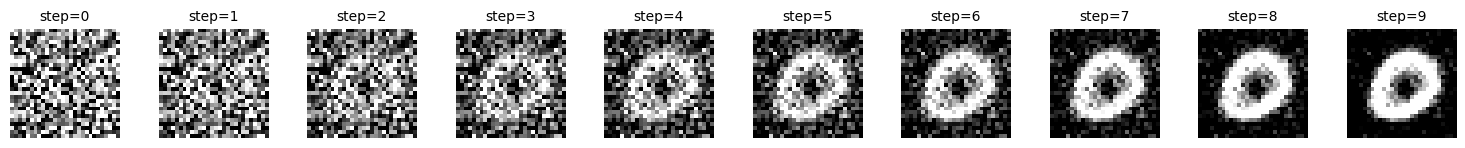

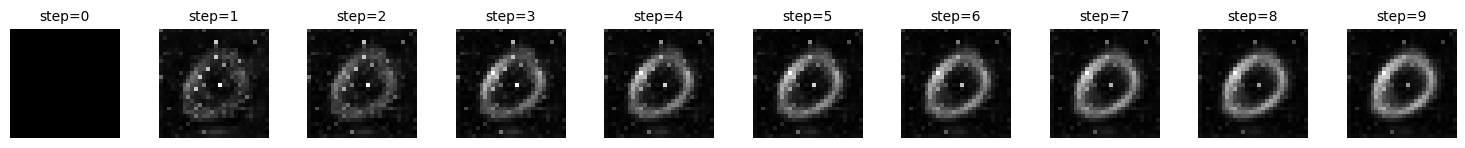

In [56]:
from PIL import Image

num_intermediate = 10
max_steps = 10

all_samples_grouped, uncertainties = plot_image_uncertainty_grid(
        laplace_model,
        flow,
        num_intermediate=num_intermediate,
        n=1,
        total_steps=max_steps,
        save_dir=save_dir,
        device=device,
        num_classes=num_classes,
        cov_num_sample=15,
    )

# Display samples grid
out_path_img = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path_img))

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")
display(Image.open(out_path_unc))


In [ ]:
print(uncertainties.shape)

torch.Size([20, 1, 1, 28, 28])


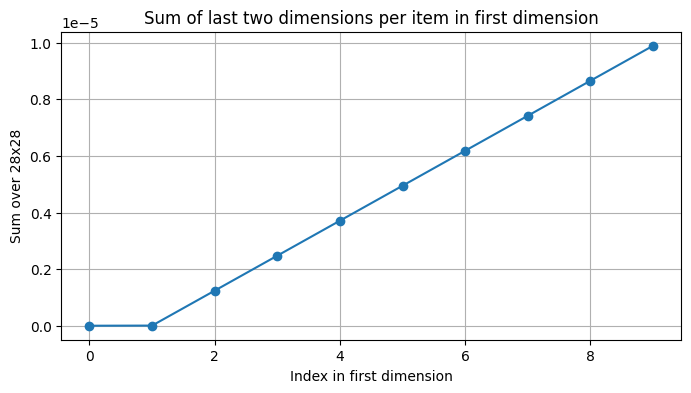

In [49]:
import torch
import matplotlib.pyplot as plt
# Sum over the last two dimensions (28x28)
sums = uncertainties.sum(dim=[-1, -2])  # shape: [10, 1, 1]

# Flatten to shape
sums_flat = sums.view(num_intermediate)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(num_intermediate), sums_flat.tolist(), marker='o', linestyle='-')
plt.title("Sum of last two dimensions per item in first dimension")
plt.xlabel("Index in first dimension")
plt.ylabel("Sum over 28x28")
plt.grid(True)
plt.show()